# Authentication

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries, download dataset, import libraries

In [ ]:
!pip -q install lightly
!pip -q install timm

In [3]:
import os
os.makedirs('/content/Ham_Train', exist_ok=True)
os.makedirs('/content/Ham_Test', exist_ok=True)

In [ ]:
!unzip /content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/HAM10000_images_part_1.zip -d /content/Ham_Train

In [ ]:
!unzip /content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/HAM10000_images_part_2.zip -d /content/Ham_Train

In [ ]:
!unzip /content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/ISIC2018_Task3_Test_Images.zip -d /content/Ham_Test

In [7]:
original_train = "/content/Ham_Train"
original_test = "/content/Ham_Test/ISIC2018_Task3_Test_Images"

In [8]:
# Path to the .DS_Store file
ds_store_path = os.path.join(original_test, '.DS_Store')

# Check if the .DS_Store file exists and then remove it
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
    print(f'Removed {ds_store_path}')
else:
    print(f'{ds_store_path} does not exist')

Removed /content/Ham_Test/ISIC2018_Task3_Test_Images/.DS_Store


In [9]:
import copy
import shutil
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from pytorch_lightning.loggers import TensorBoardLogger

from lightly.data import LightlyDataset
from lightly.loss import (
    NegativeCosineSimilarity,
    NTXentLoss,
    memory_bank,
)
from lightly.models import ResNetGenerator, modules, utils
from lightly.models.modules import heads
from lightly.transforms import SimCLRTransform
from lightly.transforms.utils import IMAGENET_NORMALIZE
from lightly.utils.benchmarking import BenchmarkModule
import timm

from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

### Image Counts and random images plotting

In [10]:
def analyze_images_in_folder(folder):
    total_images = 0
    min_size = None
    max_size = None

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if os.path.isfile(file_path):
            total_images += 1
            with Image.open(file_path) as img:
                size = img.size  # size is in (width, height)

                if min_size is None or size < min_size:
                    min_size = size
                if max_size is None or size > max_size:
                    max_size = size

    return total_images, min_size, max_size

def plot_random_images(folder_path, num_images):
    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Select a random subset of image files
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    # Calculate the layout of the subplot grid
    num_rows = (len(selected_files) - 1) // 5 + 1  # Ensure max 5 images per row
    num_cols = min(5, len(selected_files))  # Max of 5 columns

    # Create the subplot
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

    # Flatten the axes array if there are more than one row
    if num_rows > 1:
        axs = axs.flatten()

    for i, file in enumerate(selected_files):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path)
        if num_rows == 1:
            axs[i].imshow(img)
            axs[i].axis('off')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')

    # Hide any unused subplot axes if the number of selected files is not a multiple of 5
    for ax in axs[len(selected_files):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
total_images, min_size, max_size = analyze_images_in_folder(original_train)

print(f"Total number of images in the training set: {total_images}")
print(f"Minimum image size in the training set: {min_size}")
print(f"Maximum image size in the training set: {max_size}")

Total number of images in the training set: 10015
Minimum image size in the training set: (600, 450)
Maximum image size in the training set: (600, 450)


In [12]:
total_images, min_size, max_size = analyze_images_in_folder(original_test)

print(f"Total number of images in the test set: {total_images}")
print(f"Minimum image size in the training set: {min_size}")
print(f"Maximum image size in the training set: {max_size}")

Total number of images in the test set: 1511
Minimum image size in the training set: (600, 450)
Maximum image size in the training set: (600, 450)


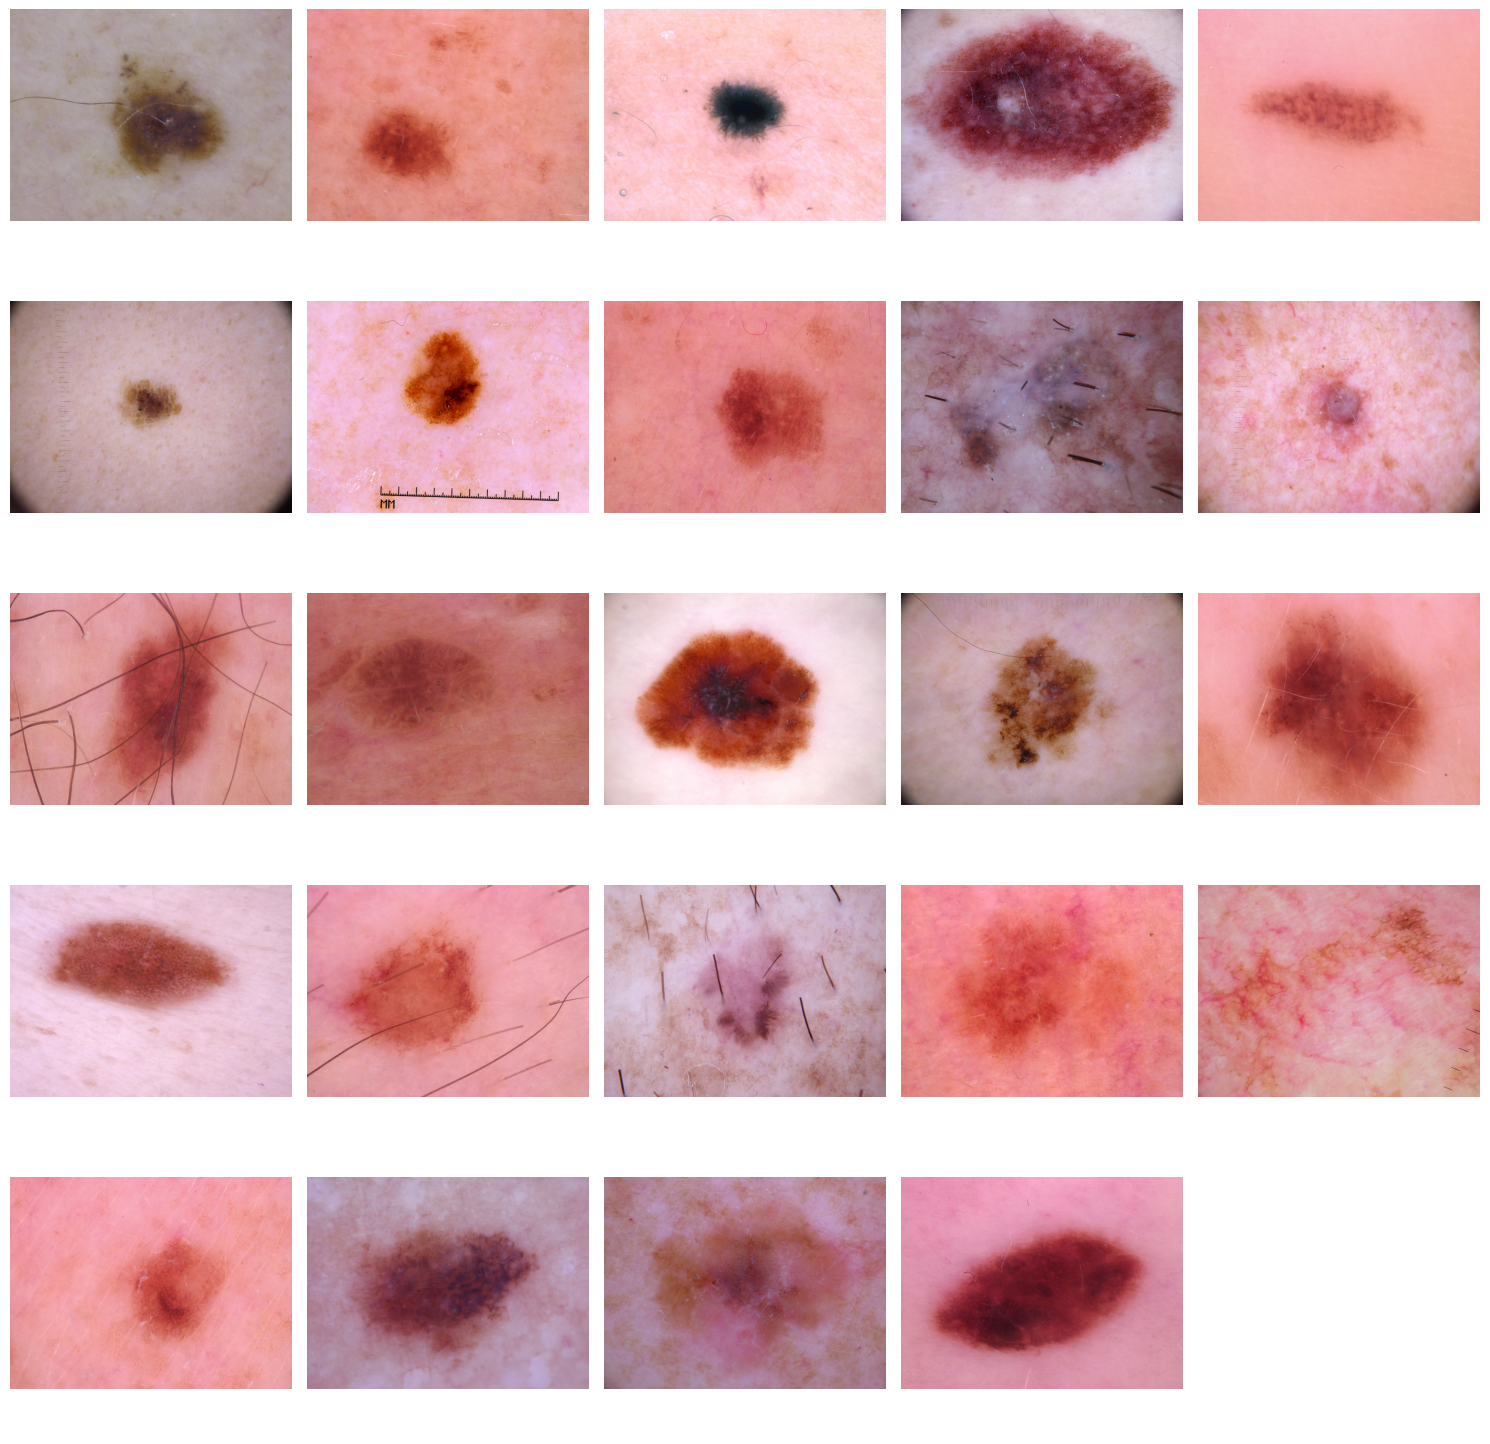

In [13]:
plot_random_images(original_train, 24)

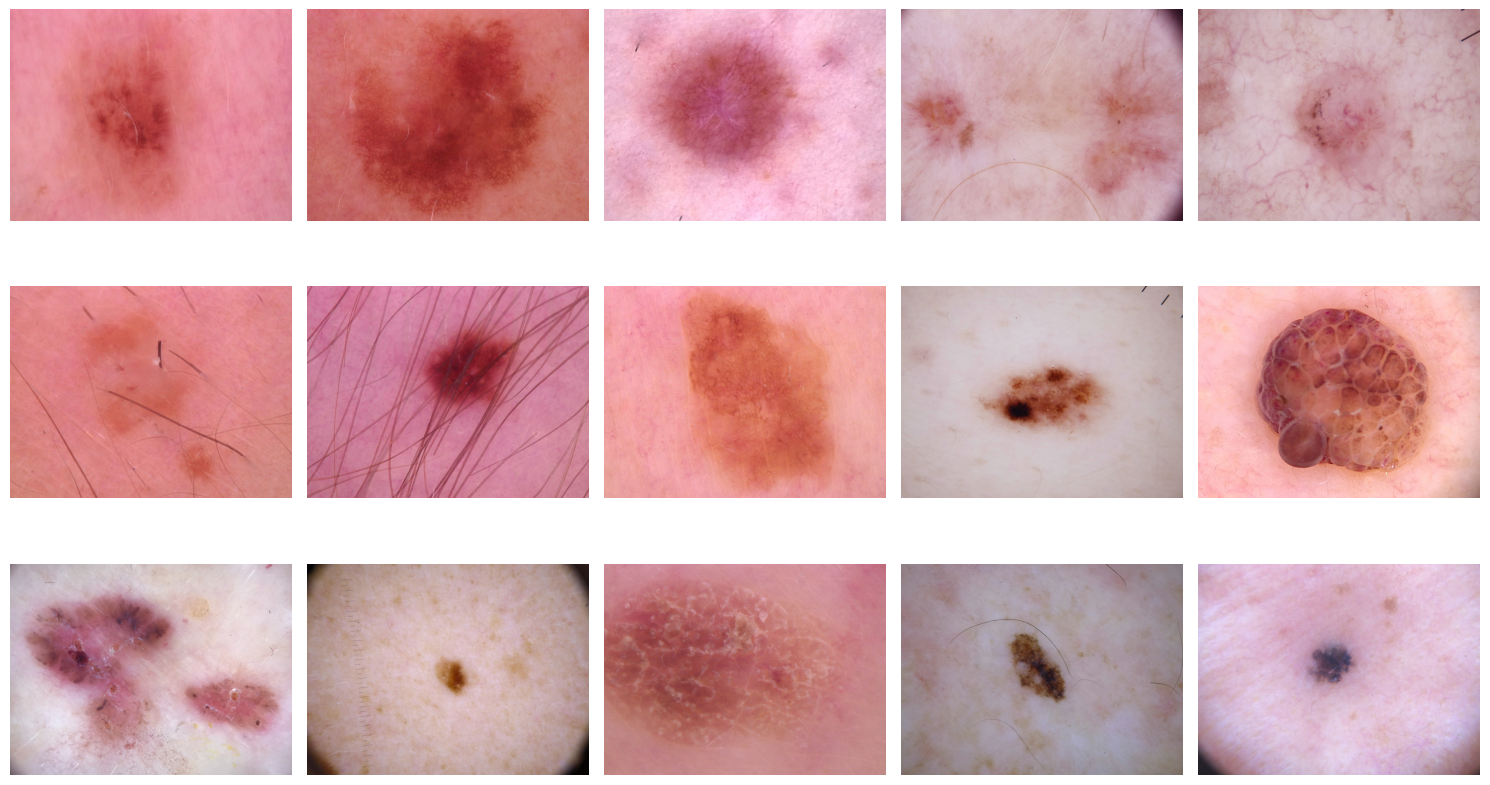

In [14]:
plot_random_images(original_test, 15)

In [15]:
import pandas as pd

# Load the CSV file

train_df = pd.read_csv('/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/HAM10000_metadata')
ground_truth_df = pd.read_csv('/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/ISIC2018_Task3_Test_GroundTruth.csv')

In [16]:
train_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

            dataset  
0      vidir_modern  
1      vidir_modern  
2      vidir_modern  
3      vidir_modern  
4      vidir_modern  
...             ...  
10010  vidir_modern  
10011  vidir_modern  
10012  vidir_modern  
10013  vidir_modern  
10014  vidir_modern  

[10015 rows x 8 columns]

In [17]:
train_df.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [18]:
ground_truth_df

lesion_id      image_id     dx    dx_type   age      sex  \
0     HAMTEST_0000000  ISIC_0034524     nv  follow_up  40.0   female   
1     HAMTEST_0000001  ISIC_0034525     nv      histo  70.0     male   
2     HAMTEST_0000002  ISIC_0034526    bkl      histo  70.0     male   
3     HAMTEST_0000003  ISIC_0034527     nv      histo  35.0     male   
4     HAMTEST_0000004  ISIC_0034528     nv  follow_up  75.0   female   
...               ...           ...    ...        ...   ...      ...   
1507  HAMTEST_0001219  ISIC_0036060    bkl  consensus   NaN  unknown   
1508  HAMTEST_0001220  ISIC_0036061     nv  consensus   NaN  unknown   
1509  HAMTEST_0001107  ISIC_0036062  akiec      histo  70.0   female   
1510  HAMTEST_0001221  ISIC_0036063    bkl  consensus   NaN  unknown   
1511  HAMTEST_0001222  ISIC_0036064    bcc      histo   NaN  unknown   

     localization        dataset  
0            back  vidir_molemax  
1         abdomen      rosendahl  
2            back      rosendahl  
3           trunk    vienna_dias  
4           trunk  vidir_molemax  
...           ...            ...  
1507      unknown       external  
1508      unknown       external  
1509         face   vidir_modern  
1510      unknown       external  
1511      unknown       external  

[1512 rows x 8 columns]

In [19]:
ground_truth_df.dx.value_counts()

nv       909
bkl      217
mel      171
bcc       93
df        44
akiec     43
vasc      35
Name: dx, dtype: int64

#structuring data folder as imagenet format using csv file

In [ ]:
# Create main folders
train_data_dir = '/content/train_data'
test_data_dir = '/content/test_data'
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)

# Function to organize images
def organize_images(df, src_path, dst_dir, id_col='image_id', label_col='dx'):
    for index, row in df.iterrows():
        # Attempt to find the image file with different extensions
        found = False
        for ext in ['jpg', 'jpeg', 'png']:
            src_file_path = os.path.join(src_path, f"{row[id_col]}.{ext}")
            if os.path.exists(src_file_path):
                found = True
                break  # Stop looking for other extensions if image is found

        if not found:
            print(f"Image {row[id_col]} not found in {src_path}")
            continue  # Skip to the next image if not found

        # Create subfolder path based on 'dx' label
        label_dir = os.path.join(dst_dir, row[label_col])
        os.makedirs(label_dir, exist_ok=True)

        # Define destination path
        dst_file_path = os.path.join(label_dir, f"{row[id_col]}.{ext}")

        # Copy the image to the corresponding subfolder
        shutil.copy(src_file_path, dst_file_path)

# Organize training images
organize_images(train_df, original_train, train_data_dir)

# Organize test images
organize_images(ground_truth_df, original_test, test_data_dir)


In [21]:
def plot_image_count(directory_path):
    """
    Plots the number of images in each class in the given directory.

    Args:
    directory_path (str): Path to the directory containing class folders.
    """
    # Dictionary to hold the count of images in each disease class
    class_image_count = {}

    # Loop through each class folder
    for class_folder in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_folder)
        if os.path.isdir(class_path):
            # Count the number of images in each class folder
            class_image_count[class_folder] = len(os.listdir(class_path))

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_image_count.keys(), class_image_count.values())
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Number of Images in Each Disease Class in {os.path.basename(directory_path)} set')

    # Adding text annotation on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()

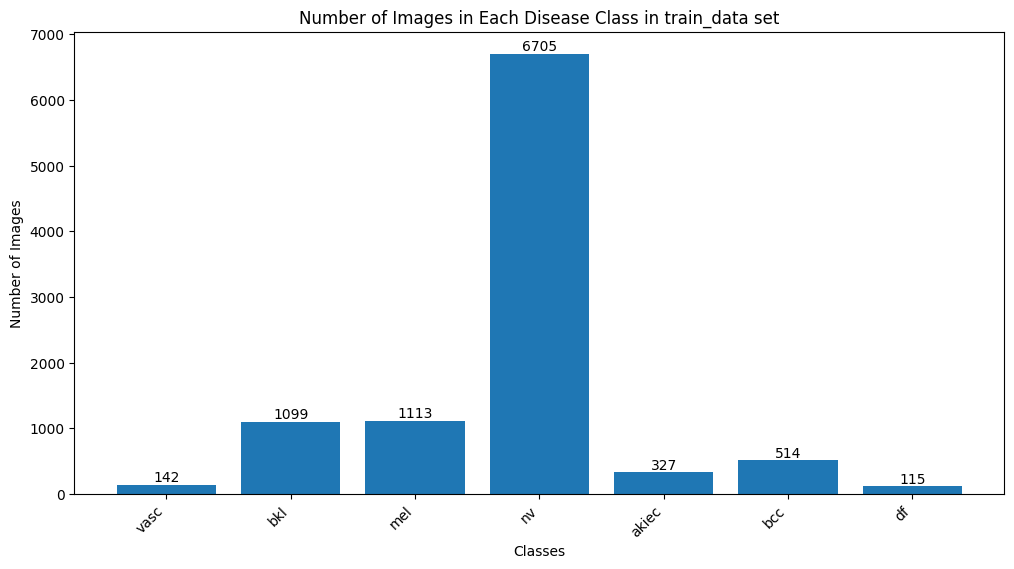

In [22]:
plot_image_count('/content/train_data')

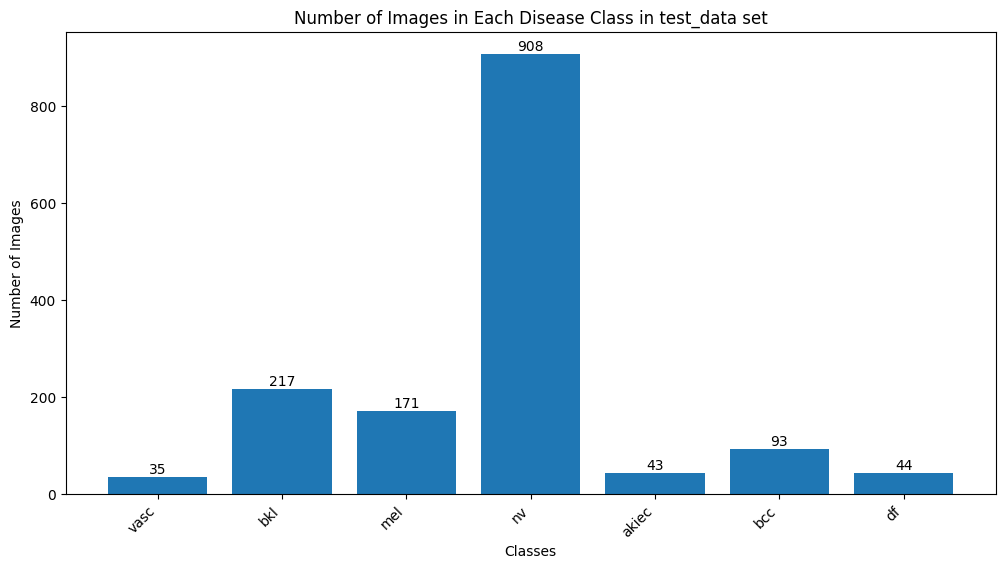

In [23]:
plot_image_count('/content/test_data')

# Parameter defining and data preparation

In [24]:
max_epochs = 40
num_workers = 4
classes = 12
seed=42
pl.seed_everything(seed)

# Set to True to enable Distributed Data Parallel training.
distributed = False

# Set to True to enable Synchronized Batch Norm (requires distributed=True).
# If enabled the batch norm is calculated over all gpus, otherwise the batch
# norm is only calculated from samples on the same gpu.
sync_batchnorm = False

# Set to True to gather features from all gpus before calculating
# the loss (requires distributed=True).
# If enabled then the loss on every gpu is calculated with features from all gpus, otherwise only features from the same gpu are used.
gather_distributed = False

# benchmark
n_runs = 1  # optional, increase to create multiple runs and report mean + std
batch_size = 128
lr_factor = batch_size / 128  # scales the learning rate linearly with batch size

# Number of devices and hardware to use for training.
devices = torch.cuda.device_count() if torch.cuda.is_available() else 1
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

if distributed:
    strategy = "ddp"
    # reduce batch size for distributed training
    batch_size = batch_size // devices
else:
    strategy = "auto"  # Set to "auto" if using PyTorch Lightning >= 2.0 otherwise None
    # limit to single device if not using distributed training
    devices = min(devices, 1)


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [25]:
# Use SimCLR augmentations
simclr_transform = SimCLRTransform(
    input_size=128,
    cj_strength=0.2,
    gaussian_blur=0.0,
    vf_prob=0.5, hf_prob = 0.5, rr_prob=0.5,
)


# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((128,128)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=IMAGENET_NORMALIZE["mean"],
            std=IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_test = LightlyDataset(input_dir=test_data_dir, transform=test_transforms)


def create_dataset_train_ssl(model):
    """Helper method to apply the correct transform for ssl.

    Args:
        model:
            Model class for which to select the transform.
    """
    model_to_transform = {
        SimCLRModel: simclr_transform,
    }
    transform = model_to_transform[model]
    return LightlyDataset(input_dir=train_data_dir, transform=transform)


def get_data_loaders(batch_size: int, dataset_train_ssl):

    dataloader_train_ssl = torch.utils.data.DataLoader(
        dataset_train_ssl,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
    )

    dataloader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
    )

    return dataloader_train_ssl, dataloader_test


# Model


In [ ]:
import timm
timm.list_models("**efficientnet**")

In [26]:
class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        efficientnet = timm.create_model('efficientnet_b4', pretrained=True)
        input_features= efficientnet.classifier.in_features
        # Remove the classifier layer
        self.backbone = nn.Sequential(
            *list(efficientnet.children())[:-1]
        )
        self.projection_head = heads.SimCLRProjectionHead(input_features, 512, 128)
        self.criterion = NTXentLoss()


    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2 * lr_factor, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [27]:
# Create datasets and dataloaders
dataset_train_simclr = create_dataset_train_ssl(SimCLRModel)
dataloader_train_simclr, dataloader_test = get_data_loaders(
    batch_size=batch_size, dataset_train_ssl=dataset_train_simclr
)

model=SimCLRModel()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [28]:
model

SimCLRModel(
  (backbone): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNormAct2d(
      48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (2): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(

# Configure logdir, callbacks and trainer

In [29]:
from pytorch_lightning.callbacks import Callback

class FileUpload(Callback):
    def __init__(self,ckptdir, weightdir,uploaddir,filename = ""):
        self.ckptdir = ckptdir
        self.weightdir = weightdir
        self.uploaddir = uploaddir
        self.filename = filename

    def on_train_epoch_end(self,trainer, pl_module):
        epoch = trainer.current_epoch+1
        ckpt_name = self.filename + f"checkpoint-epoch={epoch:02d}.pth"
        ckpt_path = os.path.join(ckptdir,ckpt_name)
        trainer.save_checkpoint(ckpt_path)
        ckpt_upload_path = self.uploaddir+"/ckpts/"
        !gsutil -mq cp {ckpt_path} {ckpt_upload_path}


class PrintMetrics(Callback):
    def on_train_epoch_end(self,trainer, pl_module):
        epoch = trainer.current_epoch+1
        metrics = {}
        for key,val in trainer.logged_metrics.items():
            metrics[key] = np.float64(val)
        print(f"Epoch-{epoch:02d}: {metrics}")

In [30]:
from pytorch_lightning.callbacks import (DeviceStatsMonitor, ModelCheckpoint,
                                         EarlyStopping, LearningRateMonitor,ModelSummary)
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer
import os
from datetime import datetime
cal_date = datetime.today().strftime('%Y-%m-%d')
date = cal_date[-2:]
month =cal_date[-5:-3]
year = cal_date[:4]

logdir = "logs/"
ckptdir = "ckpt_dir/"
weightdir = "weights/"
dir_name = "SkinDisease_Embed-PT-efficientnetb4_batch128"+f"-{date}_{month}_{year}"
uploaddir = f"/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/{dir_name}"

os.makedirs(logdir, exist_ok = True)
os.makedirs(ckptdir, exist_ok = True)
os.makedirs(weightdir,exist_ok = True)

In [31]:
## callbacks
gpu_monitor_callback = DeviceStatsMonitor()
progressbar_callback = TQDMProgressBar(refresh_rate= 3)
lr_monitor_callback = LearningRateMonitor()

fileupload_callback = FileUpload(ckptdir,weightdir,uploaddir,"SD_Embed-efficientnetb4"+"-")

callbacks = [PrintMetrics(),lr_monitor_callback,progressbar_callback,fileupload_callback,ModelSummary()]

#First Training

In [ ]:
trainer = Trainer(
                  max_epochs = max_epochs,
                  num_sanity_val_steps=1,
                  precision = "16-mixed",
                  callbacks = callbacks,
                  accumulate_grad_batches=4,
                  accelerator='gpu',
                  devices=-1,
                  strategy=strategy,
                  sync_batchnorm=sync_batchnorm,
                  reload_dataloaders_every_n_epochs = True,
                  )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dataloader_train_simclr)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 17.5 M
1 | projection_head | SimCLRProjectionHead | 984 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
18.5 M    Trainable params
0         Non-trainable params
18.5 M    Total params
74.132    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-52-ebb6631607e8>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics[key] = np.float(val)


Epoch-01: {'train_loss_ssl': 4.727836608886719}
[Errno 21] Is a directory: '/SkinDisease_Embed-PT-efficientnetb4_batch128-12_02_2024/ckpts/'
CommandException: 1 file/object could not be transferred.
Epoch-02: {'train_loss_ssl': 4.489410400390625}
Epoch-03: {'train_loss_ssl': 4.542686462402344}
Epoch-04: {'train_loss_ssl': 4.3631744384765625}
Epoch-05: {'train_loss_ssl': 4.2855072021484375}
Epoch-06: {'train_loss_ssl': 4.2917327880859375}
Epoch-07: {'train_loss_ssl': 4.305168151855469}
Epoch-08: {'train_loss_ssl': 4.271232604980469}
Epoch-09: {'train_loss_ssl': 4.1885833740234375}
Epoch-10: {'train_loss_ssl': 4.2359771728515625}
Epoch-11: {'train_loss_ssl': 4.210182189941406}
Epoch-12: {'train_loss_ssl': 4.220458984375}
Epoch-13: {'train_loss_ssl': 4.1735687255859375}
Epoch-14: {'train_loss_ssl': 4.233787536621094}
Epoch-15: {'train_loss_ssl': 4.111846923828125}
Epoch-16: {'train_loss_ssl': 4.155120849609375}
Epoch-17: {'train_loss_ssl': 4.154075622558594}
Epoch-18: {'train_loss_ssl': 4

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


#2nd Training

In [ ]:
trainer = Trainer(
                  max_epochs = 60,
                  num_sanity_val_steps=1,
                  precision = "16-mixed",
                  callbacks = callbacks,
                  accumulate_grad_batches=4,
                  accelerator='gpu',
                  devices=-1,
                  strategy=strategy,
                  sync_batchnorm=sync_batchnorm,
                  reload_dataloaders_every_n_epochs = True,
                  )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dataloader_train_simclr, ckpt_path="/content/ckpt_dir/SD_Embed-efficientnetb4-checkpoint-epoch=40.pth")


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/lightning_logs/version_1/checkpoints exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/ckpt_dir/SD_Embed-efficientnetb4-checkpoint-epoch=40.pth
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 17.5 M
1 | projection_head | SimCLRProjectionHead | 984 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
18.5 M    Trainable params
0         Non-trainable params
18.5 M    Total params
74.132    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the chec

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-52-ebb6631607e8>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics[key] = np.float(val)


Epoch-41: {'train_loss_ssl': 4.143638610839844}
Epoch-42: {'train_loss_ssl': 4.087982177734375}
Epoch-43: {'train_loss_ssl': 4.1052703857421875}
Epoch-44: {'train_loss_ssl': 4.051666259765625}
Epoch-45: {'train_loss_ssl': 4.0563507080078125}
Epoch-46: {'train_loss_ssl': 4.0563812255859375}
Epoch-47: {'train_loss_ssl': 4.1072845458984375}
Epoch-48: {'train_loss_ssl': 4.065216064453125}
Epoch-49: {'train_loss_ssl': 4.1129302978515625}
Epoch-50: {'train_loss_ssl': 4.0774078369140625}
Epoch-51: {'train_loss_ssl': 4.0913543701171875}
Epoch-52: {'train_loss_ssl': 4.080078125}
Epoch-53: {'train_loss_ssl': 4.061820983886719}
Epoch-54: {'train_loss_ssl': 4.074256896972656}
Epoch-55: {'train_loss_ssl': 4.0438995361328125}
Epoch-56: {'train_loss_ssl': 4.037086486816406}
Epoch-57: {'train_loss_ssl': 4.0586700439453125}
Epoch-58: {'train_loss_ssl': 4.004905700683594}
Epoch-59: {'train_loss_ssl': 4.0198974609375}
Epoch-60: {'train_loss_ssl': 4.003974914550781}


# 3rd Training

In [ ]:
trainer = Trainer(
                  max_epochs = 100,
                  num_sanity_val_steps=1,
                  precision = "16-mixed",
                  callbacks = callbacks,
                  accumulate_grad_batches=4,
                  accelerator='gpu',
                  devices=-1,
                  strategy=strategy,
                  sync_batchnorm=sync_batchnorm,
                  reload_dataloaders_every_n_epochs = True,
                  )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dataloader_train_simclr, ckpt_path="/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SD_Embed-efficientnetb4-checkpoint-epoch=60.pth")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SD_Embed-efficientnetb4-checkpoint-epoch=60.pth
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 17.5 M
1 | projection_head | SimCLRProjectionHead | 984 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
18.5 M    Trainable params
0         Non-trainable params
18.5 M    Total params
74.132    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SD_Embed-efficientnetb4-checkpoint-epoch=60.pth

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-28-ebb6631607e8>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metrics[key] = np.float(val)


Epoch-61: {'train_loss_ssl': 4.051948547363281}
[Errno 21] Is a directory: '/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SkinDisease_Embed-PT-efficientnetb4_batch128-13_02_2024/ckpts/'
CommandException: 1 file/object could not be transferred.
Epoch-62: {'train_loss_ssl': 4.0636444091796875}
Epoch-63: {'train_loss_ssl': 4.021575927734375}
Epoch-64: {'train_loss_ssl': 4.014732360839844}
Epoch-65: {'train_loss_ssl': 4.0233154296875}
Epoch-66: {'train_loss_ssl': 4.0403900146484375}
Epoch-67: {'train_loss_ssl': 4.03521728515625}
Epoch-68: {'train_loss_ssl': 3.983978271484375}
Epoch-69: {'train_loss_ssl': 4.03350830078125}
Epoch-70: {'train_loss_ssl': 4.026649475097656}
Epoch-71: {'train_loss_ssl': 4.0661773681640625}
Epoch-72: {'train_loss_ssl': 4.001007080078125}
Epoch-73: {'train_loss_ssl': 4.053741455078125}
Epoch-74: {'train_loss_ssl': 3.9840545654296875}
Epoch-75: {'train_loss_ssl': 4.001564025878906}
Epoch-76: {'train_loss_ssl': 4.00494384765625}
Epoch-77: 

# 4th Training

In [41]:
trainer = Trainer(
                  max_epochs = 100,
                  num_sanity_val_steps=1,
                  precision = "16-mixed",
                  callbacks = callbacks,
                  accumulate_grad_batches=4,
                  accelerator='gpu',
                  devices=-1,
                  strategy=strategy,
                  sync_batchnorm=sync_batchnorm,
                  reload_dataloaders_every_n_epochs = True,
                  )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dataloader_train_simclr, ckpt_path="/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SkinDisease_Embed-PT-efficientnetb4_batch128-13_02_2024/ckpts/SD_Embed-efficientnetb4-checkpoint-epoch=80.pth")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SkinDisease_Embed-PT-efficientnetb4_batch128-13_02_2024/ckpts/SD_Embed-efficientnetb4-checkpoint-epoch=80.pth
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: The dirpath has changed from '/content/lightning_logs/version_0/checkpoints' to '/content/lightning_logs/version_1/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 17.5 M
1 | projection_head | SimCLRProjectionHead | 984 K

Training: |          | 0/? [00:00<?, ?it/s]

Epoch-81: {'train_loss_ssl': 3.9883575439453125}
[Errno 21] Is a directory: '/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SkinDisease_Embed-PT-efficientnetb4_batch128-14_02_2024/ckpts/'
CommandException: 1 file/object could not be transferred.
Epoch-82: {'train_loss_ssl': 3.9660720825195312}
Epoch-83: {'train_loss_ssl': 4.007911682128906}
Epoch-84: {'train_loss_ssl': 3.9679946899414062}
Epoch-85: {'train_loss_ssl': 3.9535064697265625}
Epoch-86: {'train_loss_ssl': 3.9180831909179688}
Epoch-87: {'train_loss_ssl': 3.9628982543945312}
Epoch-88: {'train_loss_ssl': 3.9717330932617188}
Epoch-89: {'train_loss_ssl': 3.9729537963867188}
Epoch-90: {'train_loss_ssl': 4.036781311035156}
Epoch-91: {'train_loss_ssl': 3.9335556030273438}
Epoch-92: {'train_loss_ssl': 4.00518798828125}
Epoch-93: {'train_loss_ssl': 3.9692916870117188}
Epoch-94: {'train_loss_ssl': 4.038185119628906}
Epoch-95: {'train_loss_ssl': 3.9693603515625}
Epoch-96: {'train_loss_ssl': 4.02197265625}
Epoch-

#5th training

In [37]:
trainer = Trainer(
                  max_epochs = 115,
                  num_sanity_val_steps=1,
                  precision = "16-mixed",
                  callbacks = callbacks,
                  accumulate_grad_batches=4,
                  accelerator='gpu',
                  devices=-1,
                  strategy=strategy,
                  sync_batchnorm=sync_batchnorm,
                  reload_dataloaders_every_n_epochs = True,
                  )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [38]:
trainer.fit(model, dataloader_train_simclr, ckpt_path="/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SkinDisease_Embed-PT-efficientnetb4_batch128-14_02_2024/ckpts/SD_Embed-efficientnetb4-checkpoint-epoch=99.pth")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SkinDisease_Embed-PT-efficientnetb4_batch128-14_02_2024/ckpts/SD_Embed-efficientnetb4-checkpoint-epoch=99.pth
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: The dirpath has changed from '/content/lightning_logs/version_1/checkpoints' to '/content/lightning_logs/version_0/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 17.5 M
1 | projection_head | SimCLRProjectionHead | 984 K

Training: |          | 0/? [00:00<?, ?it/s]

Epoch-100: {'train_loss_ssl': 3.9622726440429688}
[Errno 21] Is a directory: '/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SkinDisease_Embed-PT-efficientnetb4_batch128-15_02_2024/ckpts/'
CommandException: 1 file/object could not be transferred.
Epoch-101: {'train_loss_ssl': 4.04034423828125}
Epoch-102: {'train_loss_ssl': 3.9690628051757812}
Epoch-103: {'train_loss_ssl': 4.0130615234375}
Epoch-104: {'train_loss_ssl': 4.007667541503906}
Epoch-105: {'train_loss_ssl': 3.9861602783203125}
Epoch-106: {'train_loss_ssl': 4.0063323974609375}
Epoch-107: {'train_loss_ssl': 3.9650115966796875}
Epoch-108: {'train_loss_ssl': 3.961517333984375}
Epoch-109: {'train_loss_ssl': 3.9720687866210938}
Epoch-110: {'train_loss_ssl': 3.996337890625}
Epoch-111: {'train_loss_ssl': 3.9487152099609375}
Epoch-112: {'train_loss_ssl': 3.9738998413085938}
Epoch-113: {'train_loss_ssl': 3.9923477172851562}
Epoch-114: {'train_loss_ssl': 3.9850234985351562}
Epoch-115: {'train_loss_ssl': 3.958618

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=115` reached.


In [ ]:
# import shutil
# source_file = '/content/ckpt_dir/SD_Embed-efficientnetb4-checkpoint-epoch=100.pth'
# destination_folder = '/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint'
# shutil.copy(source_file, destination_folder)

# Generate embeddings

In [32]:
checkpoint_path = '/content/drive/MyDrive/Dataset/HAM10000_dermastoscopic_images/checkpoint/SkinDisease_Embed-PT-efficientnetb4_batch128-14_02_2024/ckpts/SD_Embed-efficientnetb4-checkpoint-epoch=86.pth'
checkpoint = torch.load(checkpoint_path,)     # if on cpu -->> map_location=torch.device('cpu')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [39]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [ ]:
# #if on cpu

# def generate_embeddings(model, dataloader):
#     """Generates representations for all images in the dataloader with the given model."""

#     embeddings = []
#     filenames = []
#     with torch.no_grad():
#         for img, _, fnames in dataloader:
#             img = img.to(model.device)
#             emb = model.backbone(img).flatten(start_dim=1)
#             embeddings.append(emb.cpu())  # Move embeddings to CPU
#             filenames.extend(fnames)

#     embeddings = torch.cat(embeddings, 0)
#     embeddings = torch.nn.functional.normalize(embeddings, dim=1)  # Normalize embeddings

#     return embeddings, filenames

# # Make sure the model is in evaluation mode
# model.eval()

# # Generate embeddings and filenames
# embeddings, filenames = generate_embeddings(model, dataloader_test)


In [34]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=5, num_examples=10):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(test_data_dir, filenames[neighbor_idx])

            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

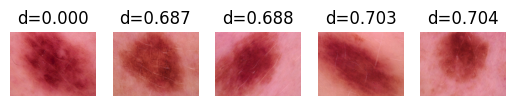

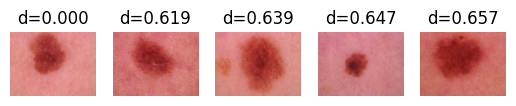

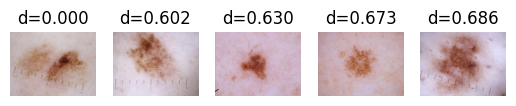

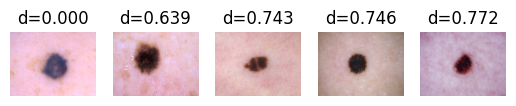

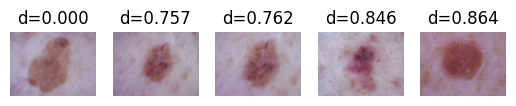

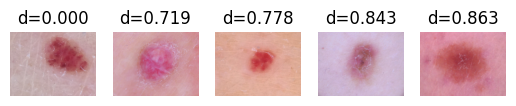

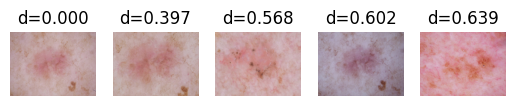

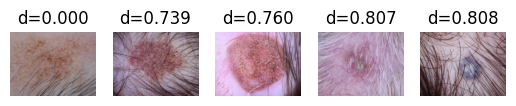

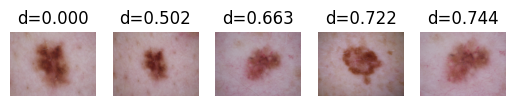

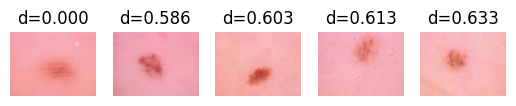

In [35]:
plot_knn_examples(embeddings, filenames)

In [36]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import numpy as np

nbrs_86 = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(embeddings)

# Perform kNN search
distances, indices = nbrs_86.kneighbors(embeddings)

# Get all subfolders (class folders)
class_folders = sorted(os.listdir(test_data_dir))

# Dictionary mapping class names to labels
class_to_label = {class_name: i for i, class_name in enumerate(class_folders)}

true_labels = []
for class_name in class_folders:
    class_dir = os.path.join(test_data_dir, class_name)
    files = os.listdir(class_dir)
    true_labels.extend([class_to_label[class_name]] * len(files))

true_labels = np.array(true_labels)

# Evaluate correctness for each query embedding
predicted_labels = []
for i, neighbors in enumerate(indices):
    neighbor_labels = true_labels[neighbors[1:]]  # Exclude self

    mode_label = np.argmax(np.bincount(neighbor_labels))
    predicted_labels.append(mode_label)

predicted_labels = np.array(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73


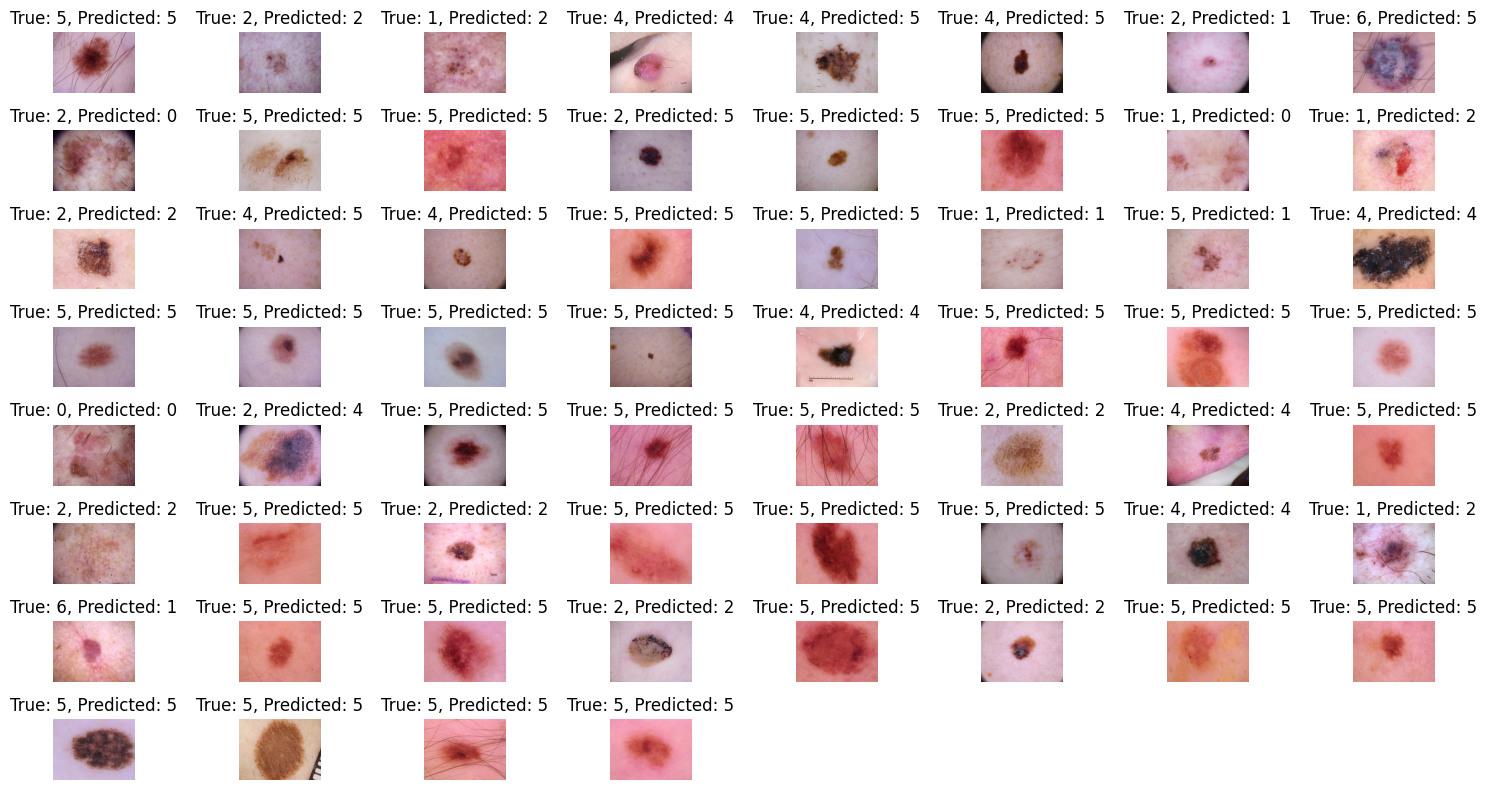

In [35]:
import random
from PIL import Image

# Choosing random examples to visualize
num_examples_to_visualize = 60
sample_indices = random.sample(range(len(true_labels)), num_examples_to_visualize)

# Visualize the examples
num_cols = 8
num_rows = num_examples_to_visualize // num_cols + (num_examples_to_visualize % num_cols > 0)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices, 1):
    plt.subplot(num_rows, num_cols, i)

    # Get the corresponding filename for the current index
    fname = os.path.join(test_data_dir, filenames[idx])

    # Load the image
    img = Image.open(fname)
    plt.imshow(img)
    plt.title(f"True: {true_labels[idx]}, Predicted: {predicted_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
